In [95]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import sklearn as sk
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [ ]:
model_path = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/GAP_tf_model2.h5'

In [118]:
model = keras.models.load_model(model_path)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)      

In [283]:
def visualize_data(train_ds):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(train_ds.class_names[labels[i]])
            plt.axis("off")


def generate_predictions(dataset):
    predictions = []
    true_labels = []
    for img, lbl in dataset:
        pred = model.predict(img)
        pred = [np.argmax(i) for i in pred]
        label = list(lbl.numpy())
        predictions.extend(pred)
        true_labels.extend(label)
    
    return predictions, true_labels


def build_confusion_matrix(true_labels, predictions, dataset):
    confusion_matrix = tf.math.confusion_matrix(true_labels, predictions).numpy()
    class_names = dataset.class_names
    fig, ax = plt.subplots(figsize=(10,7))
    tick_marks = np.arange(len(class_names)) + 0.5
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlOrBr" ,fmt='g')
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=45)
    ax.xaxis.set_label_position("top")
    #plt.tight_layout()
    plt.title('Brain Tumor Classification CNN: Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def load_image_array(img_path, image_size=(128,128)):
    img = img_to_array(load_img(img_path, target_size=image_size))
    img = np.expand_dims(img, axis=0)
    return img


def visualize_layer_activations(test_image, layer_vis_model):
    features = layer_vis_model.predict(test_image)
    fig = plt.figure(figsize=(20,15))
    for i in range(1, features.shape[3]+1):
        plt.subplot(16, 16, i)
        plt.imshow(features[0, :, :, i-1])
    plt.show()


def get_last_conv_layer_index(model):
    layers = model.layers
    conv_indexes = []
    for layer in range(len(layers)):
        if 'conv' in layers[layer].name:
            conv_indexes.append(layer)
    final_conv_idx = max(conv_indexes)
    return final_conv_idx


def class_activation_map(img_arr, model, final_conv_layer_idx, prediction_index=None):
    cam_model = Model([model.inputs], [model.layers[final_conv_layer_idx].output, model.output])

    with tf.GradientTape() as tape:
        final_conv_layer_output, predictions = cam_model(img_arr)
        if prediction_index is None:
            prediction_index = np.argmax(predictions[0])
        class_channel = predictions[:, prediction_index]

    gradients = tape.gradient(class_channel, final_conv_layer_output)
    pooled_gradients = tf.reduce_mean(gradients, axis=(0,1,2))
    final_conv_layer_output = final_conv_layer_output[0]
    heatmap = final_conv_layer_output @ pooled_gradients[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap
    

def plot_superimposed_map(heatmap, orig_test_image, alpha=0.7):
    orig_img = img_to_array(load_img(orig_test_image))
    heatmap = heatmap.numpy()
    heatmap = np.uint8(255 * heatmap)
    cmap = cm.get_cmap('jet')
    colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = colors[heatmap]
    cmap_heatmap = keras.utils.array_to_img(cmap_heatmap)
    cmap_heatmap = cmap_heatmap.resize((orig_img.shape[1], orig_img.shape[0]))
    cmap_heatmap = img_to_array(cmap_heatmap)

    superimposed_img = cmap_heatmap * alpha + orig_img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [120]:
image_height = 128
image_width = 128
data_dir = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/data/Testing'

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(image_height, image_width))

Found 1311 files belonging to 4 classes.


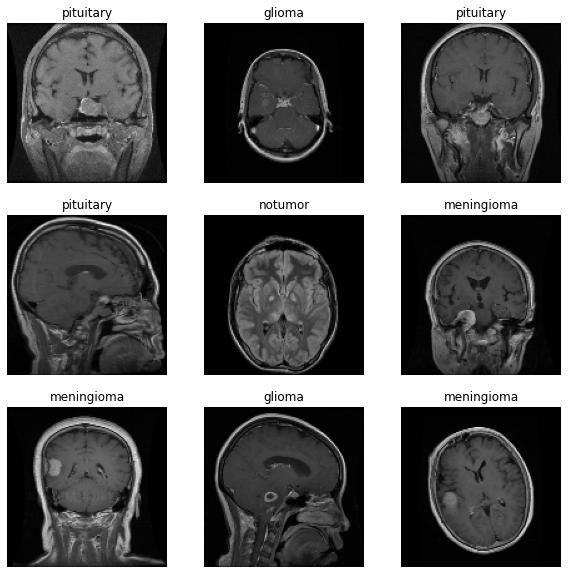

In [99]:
visualize_data(test_ds)

In [121]:
model.evaluate(test_ds, batch_size=32)

2023-12-12 14:38:44.125414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 7s 114ms/step - loss: 0.7667 - accuracy: 0.9687


[0.766670823097229, 0.9687261581420898]

2023-12-12 14:38:58.467423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-12-12 14:39:03.312162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


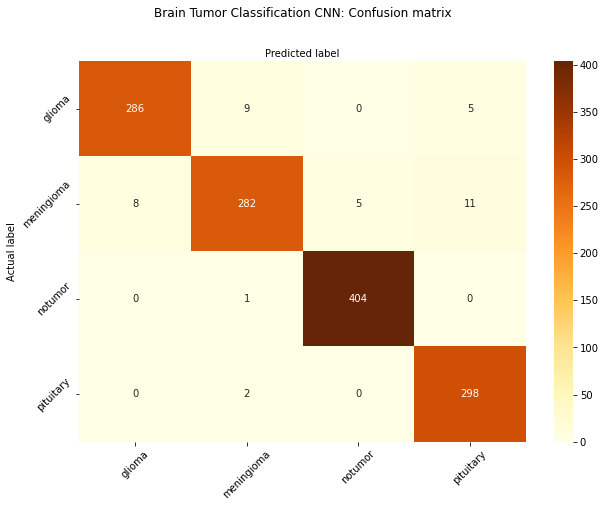

In [122]:
predictions, true_labels = generate_predictions(test_ds)
build_confusion_matrix(true_labels, predictions, test_ds)

In [123]:
print(classification_report(true_labels, predictions, target_names=test_ds.class_names))

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.96      0.92      0.94       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



## Class Activation Map Visualization

<Figure size 432x288 with 0 Axes>

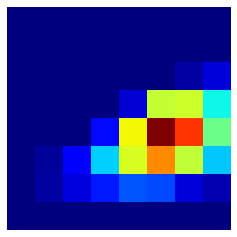

In [286]:
_TEST_IMAGE_DIR = "/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/data/Testing"
orig_test_image = os.path.join(_TEST_IMAGE_DIR, "glioma/Te-gl_0023.jpg")
test_image_arr = load_image_array(orig_test_image)
final_layer_index = get_last_conv_layer_index(model)
heatmap = class_activation_map(test_image_arr, model, final_layer_index, prediction_index=1)
cmap = plt.get_cmap('jet')
plt.set_cmap(cmap)
plt.matshow(heatmap)
plt.axis('off')
plt.show()

Prediction: glioma


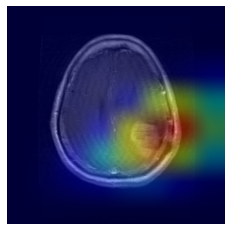

In [287]:
print("Prediction:", test_ds.class_names[np.argmax(model.predict(test_image_arr))])
plot_superimposed_map(heatmap, orig_test_image)